<h4> Introduction</h4>
The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

<h4> Importing Required Library

In [1]:
#data Manipulation
import pandas as pd

#Mathematical operation
import numpy as np

#data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

#Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the Dataset
df=pd.read_csv(r"C:\Users\Lenovo\Documents\jupyter\DataSets\titanic.csv")

In [3]:
# Check starting five rows of the dataset
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Check the shape of the Dataset
df.shape

(891, 12)

<h1> Exploratory Data Analysis

###  Overview:
* `PassengerId` is the unique id of the row and it doesn't have any effect on target
* `Survived` is the target variable we are trying to predict (**0** or **1**):
    - **1 = Survived**
    - **0 = Not Survived**
* `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has **3** unique values (**1**,  **2 **or **3**):
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
* `Name`, `Sex` and `Age` are self-explanatory
* `SibSp` is the total number of the passengers' siblings and spouse
* `Parch` is the total number of the passengers' parents and children
* `Ticket` is the ticket number of the passenger
* `Fare` is the passenger fare
* `Cabin` is the cabin number of the passenger
* `Embarked` is port of embarkation and it is a categorical feature which has **3** unique values (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### **1.2 Missing Values**

In [6]:
def display_missing(df):
    for col in df.columns.tolist():          
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
display_missing(df)

PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2



As seen from above cell, some columns have missing values. `display_missing` function shows the count of missing values in every column in dataset.
* dataset have missing values in `Age`, `Cabin` and `Embarked` columns

 The count of missing values in `Age`, `Embarked` and `Fare` are smaller compared to total sample, but roughly **80%** of the `Cabin` is missing. Missing values in `Age`, `Embarked` and `Fare` can be filled with descriptive statistical measures but that wouldn't work for `Cabin`.

In [7]:
df_corr = df.corr().abs().unstack().sort_values( ascending=False).reset_index()
df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_corr[df_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
5,Age,Age,1.000000
12,Age,Pclass,0.369226
16,Age,SibSp,0.308247
21,Age,Parch,0.189119
26,Age,Fare,0.096067
32,Age,Survived,0.077221
36,Age,PassengerId,0.036847


### **1.2.1 Age**
Missing values in `Age` are filled with median age, but using median age of the whole data set is not a good choice. Median age of `Pclass` groups is the best choice because of its high correlation with `Age` **(0.408106)** and `Survived` **(0.338481)**. It is also more logical to group ages by passenger classes instead of other features.

In [8]:
age_by_pclass_sex = df.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 35.0
Median age of Pclass 1 males: 40.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 30.0
Median age of Pclass 3 females: 21.5
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In order to be more accurate, `Sex` feature is used as the second level of `groupby` while filling the missing `Age` values. As seen from above cell, `Pclass` and `Sex` groups have distinct median `Age` values. When passenger class increases, the median age for both males and females also increases. However, females tend to have slightly lower median `Age` than males. The median ages below are used for filling the missing values in `Age` feature.

#### **1.2.2 Embarked**
`Embarked` is a categorical feature and there are only **2** missing values in whole data set. Both of those passengers are female, upper class and they have the same ticket number. This means that they know each other and embarked from the same port together. The mode `Embarked` value for an upper class female passenger is **C (Cherbourg)**, but this doesn't necessarily mean that they embarked from that port.

In [9]:
df[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


When I googled **Stone, Mrs. George Nelson (Martha Evelyn)**, I found that she embarked from **S (Southampton)** with her maid **Amelie Icard**, in this page [Martha Evelyn Stone: Titanic Survivor](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html).

> *Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.*

Missing values in `Embarked` are filled with **S** with this information.

In [10]:
# Filling the missing values in Embarked with S
df['Embarked'] = df['Embarked'].fillna('S')

#### **1.2.3 Cabin**
`Cabin` feature is little bit tricky and it needs further exploration. The large portion of the `Cabin` feature is missing and the feature itself can't be ignored completely because some the cabins might have higher survival rates. It turns out to be the first letter of the `Cabin` values are the decks in which the cabins are located. Those decks were mainly separated for one passenger class, but some of them were used by multiple passenger classes.
![alt text](https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733)
* On the Boat Deck there were **6** rooms labeled as **T, U, W, X, Y, Z** but only the **T** cabin is present in the dataset
* **A**, **B** and **C** decks were only for 1st class passengers
* **D** and **E** decks were for all classes
* **F** and **G** decks were for both 2nd and 3rd class passengers
* From going **A** to **G**, distance to the staircase increases which might be a factor of survival

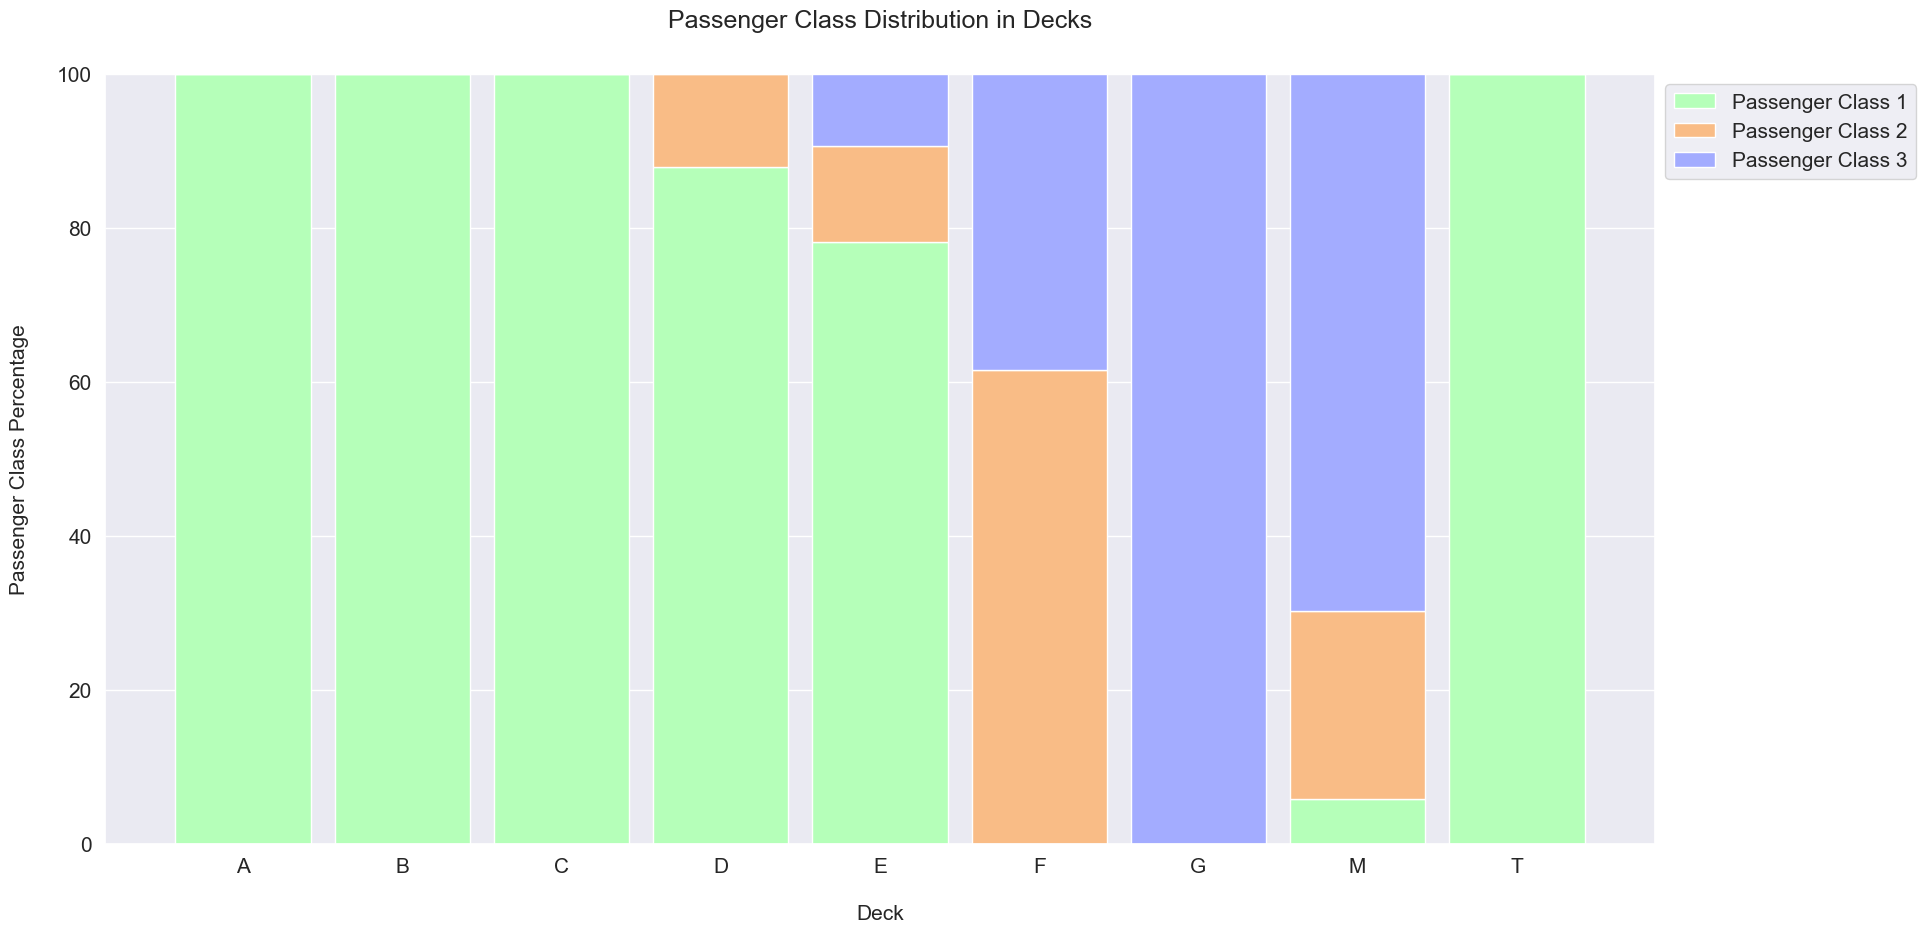

In [11]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_decks = df.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_decks)
display_pclass_dist(all_deck_per)

* **100%** of **A**, **B** and **C** decks are 1st class passengers
* Deck **D** has **87%** 1st class and **13%** 2nd class passengers
* Deck **E** has **83%** 1st class, **10%** 2nd class and **7%** 3rd class passengers
* Deck **F** has **62%** 2nd class and **38%** 3rd class passengers
* **100%** of **G** deck are 3rd class passengers
* There is one person on the boat deck in **T** cabin and he is a 1st class passenger. **T** cabin passenger has the closest resemblance to **A** deck passengers so he is grouped with **A** deck
* Passengers labeled as **M** are the missing values in `Cabin` feature. I don't think it is possible to find those passengers' real `Deck` so I decided to use **M** like a deck

In [12]:
# Passenger in the T deck is changed to A
idx = df[df['Deck'] == 'T'].index
df.loc[idx, 'Deck'] = 'A'

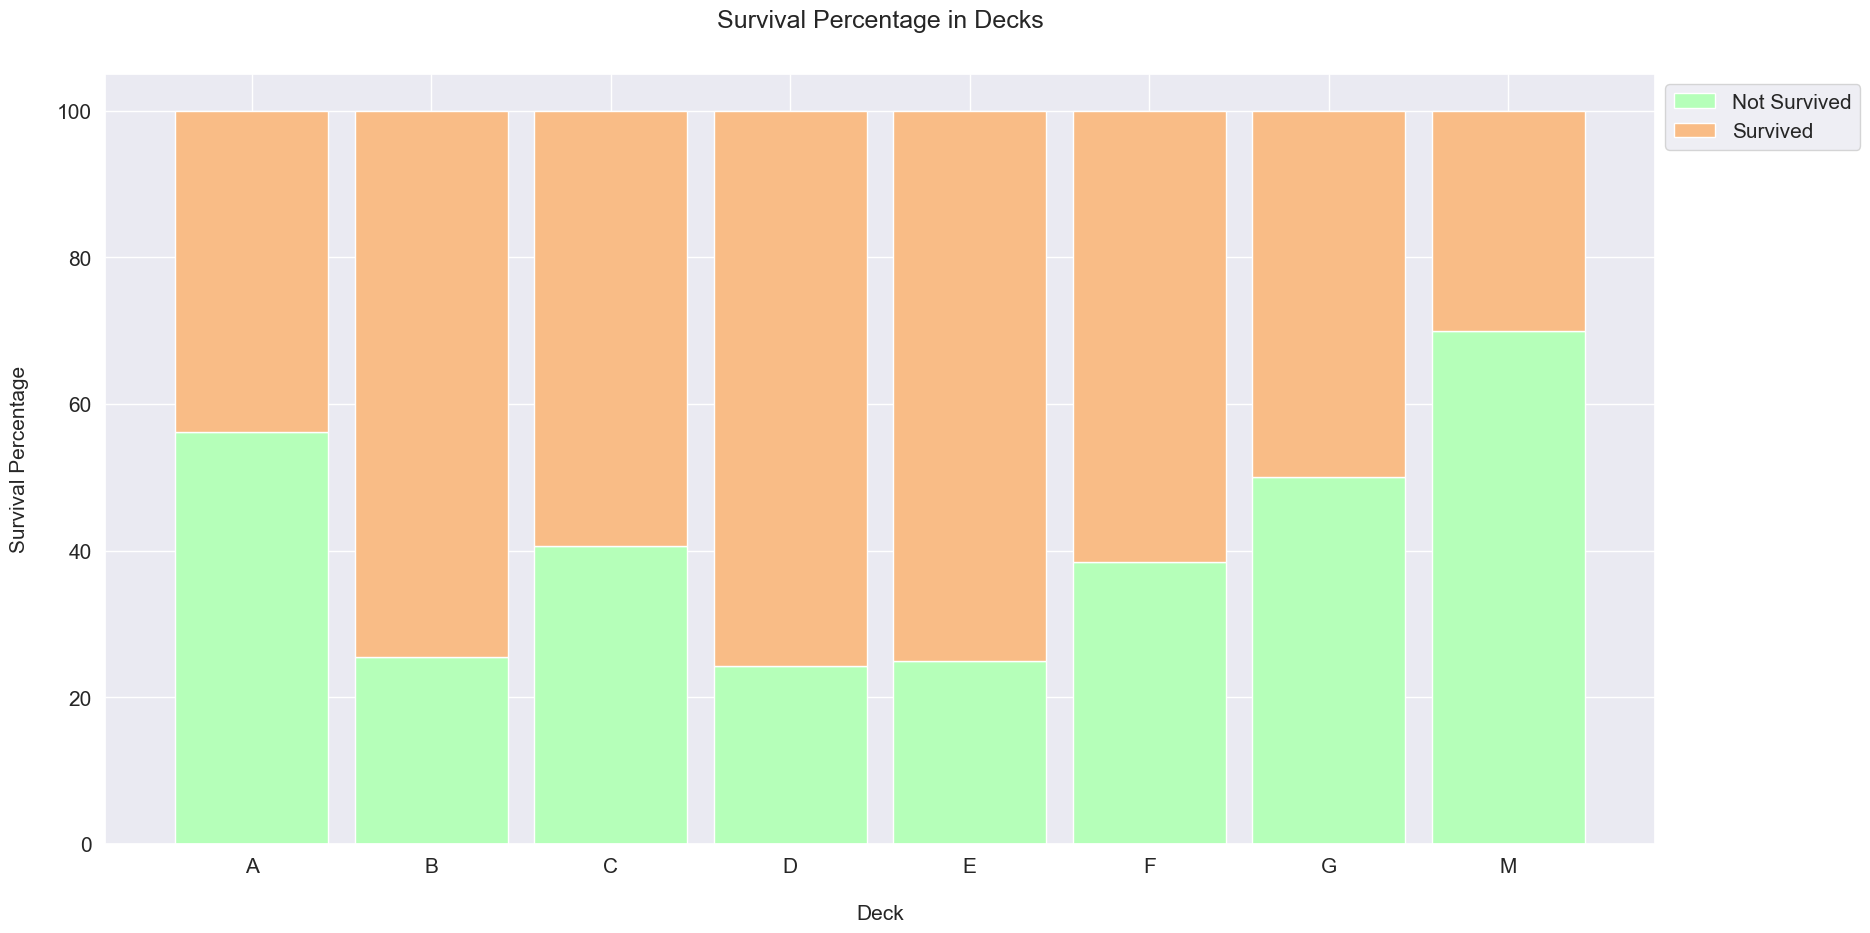

In [13]:
df_decks_survived = df.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_decks_survived)
display_surv_dist(all_surv_per)

As I suspected, every deck has different survival rates and that information can't be discarded. Deck **B**, **C**, **D** and **E** have the highest survival rates. Those decks are mostly occupied by 1st class passengers. **M** has the lowest survival rate which is mostly occupied by 2nd and 3rd class passengers. To conclude, cabins used by 1st class passengers have higher survival rates than cabins used by 2nd and 3rd class passengers. In my opinion **M** (Missing `Cabin` values) has the lowest survival rate because they couldn't retrieve the cabin data of the victims. That's why I believe labeling that group as **M** is a reasonable way to handle the missing data. It is a unique group with shared characteristics. `Deck` feature has high-cardinality right now so some of the values are grouped with each other based on their similarities.
* **A**, **B** and **C** decks are labeled as **ABC** because all of them have only 1st class passengers
* **D** and **E** decks are labeled as **DE** because both of them have similar passenger class distribution and same survival rate
* **F** and **G** decks are labeled as **FG** because of the same reason above
* **M** deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.

In [14]:
df['Deck'] = df['Deck'].replace(['A', 'B', 'C'], 'ABC')
df['Deck'] = df['Deck'].replace(['D', 'E'], 'DE')
df['Deck'] = df['Deck'].replace(['F', 'G'], 'FG')

df['Deck'].value_counts()

M      687
ABC    122
DE      65
FG      17
Name: Deck, dtype: int64

After filling the missing values in `Age`, `Embarked`, `Fare` and `Deck` features, there is no missing value left in data set. `Cabin` is dropped because `Deck` feature is used instead of it.

In [15]:
# Dropping the Cabin feature
df.drop(['Cabin'], inplace=True, axis=1)

display_missing(df)

PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 0
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Embarked column missing values: 0
Deck column missing values: 0


### **1.3 Target Distribution**
* **38.38%** (342/891) of training set is **Class 1**
* **61.62%** (549/891) of training set is **Class 0**

In [16]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

342 of 891 passengers survived and it is the 38.38% of the dataset.
549 of 891 passengers didnt survive and it is the 61.62% of the dataset set.


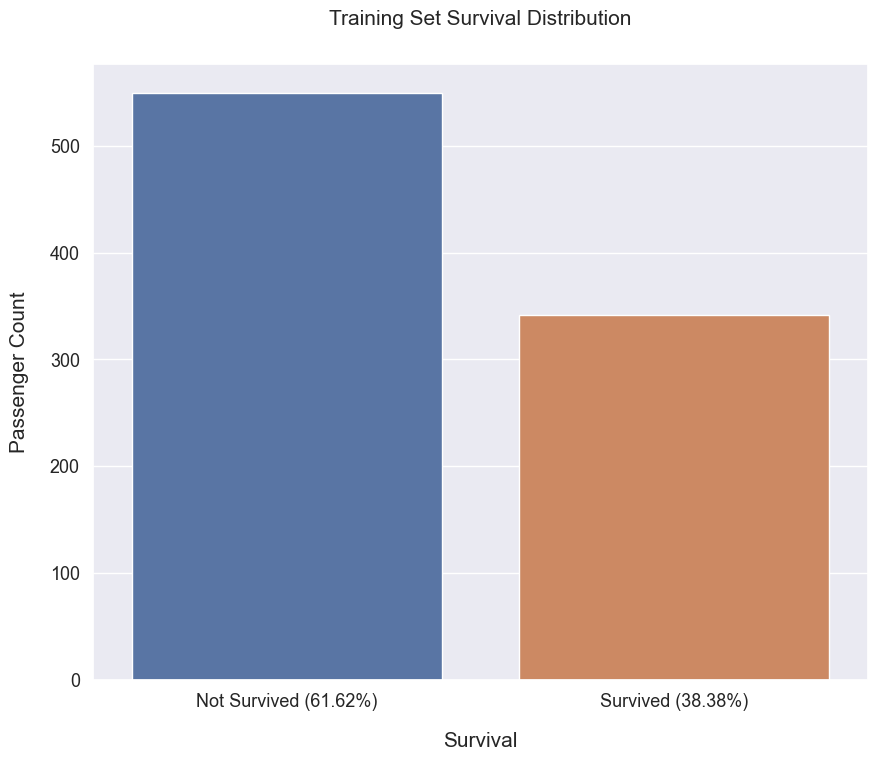

In [17]:
survived = df['Survived'].value_counts()[1]
not_survived = df['Survived'].value_counts()[0]
survived_per = survived / df.shape[0] * 100
not_survived_per = not_survived / df.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the dataset.'.format(survived, df.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the dataset set.'.format(not_survived, df.shape[0], not_survived_per))

plt.figure(figsize=(10, 8))
sns.countplot(x=df['Survived'],data=df)

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

### **1.4 Correlations**

In [18]:
df_corr = df.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_corr.drop(df_corr.iloc[1::2].index, inplace=True)
df_corr_nd = df_corr.drop(df_corr[df_corr['Correlation Coefficient'] == 1.0].index)



In [19]:
#Highly corelated features
corr = df_corr_nd['Correlation Coefficient'] > 0.1
df_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.549500
8,Parch,SibSp,0.414838
10,Age,Pclass,0.413583
12,Survived,Pclass,0.338481
14,Fare,Survived,0.257307
16,SibSp,Age,0.249854
18,Fare,Parch,0.216225
20,Age,Parch,0.175526
22,SibSp,Fare,0.159651
24,Age,Fare,0.122692


Features are highly correlated with each other and dependent to each other. The highest correlation between features is **0.549500** in data set  between `Fare` and `Pclass`. The other features are also highly correlated. There are **10** correlations in our data set that are higher than **0.1**.

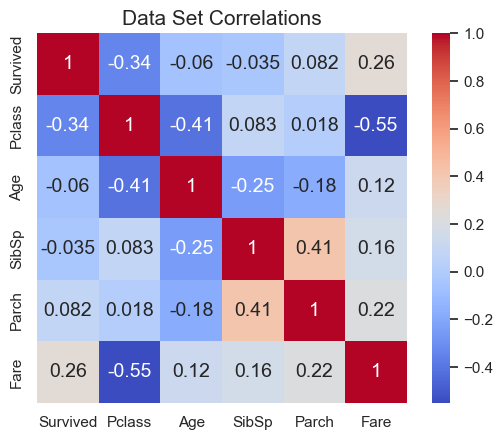

In [20]:
fig = plt.plot(figsize=(20, 20))

sns.heatmap(df.drop(['PassengerId'],axis=1).corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
    
plt.title('Data Set Correlations', size=15)

plt.show()

In [21]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,M
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,ABC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,M
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,ABC
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,M
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,M
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,ABC
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.5,1,2,W./C. 6607,23.4500,S,M
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,ABC
